# Climate Analysis

### Part 1: SQLAlchemy Object Relational Mapper

#### Initial Exploration and Analysis

In [1]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [3]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

#### Precipitation Analysis

In [8]:
# inspect measurement columns
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [74]:
# calculate last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

In [75]:
# date 1 year ago from latest_date 
year_ago = dt.datetime.strptime(latest_date,"%Y-%m-%d") - dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [76]:
# retrieve the data and precipitation scores
last_year = session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date>=year_ago).all()

In [77]:
# save query results as a Pandas DataFrame and set the index to the date column, sort df by date
prcp_df = pd.DataFrame(last_year, columns=["Date","Precipitation"])
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"], format="%Y-%m-%d")
prcp_df.set_index("Date", inplace=True)
sorted_df = prcp_df.sort_values(by="Date", ascending=True)

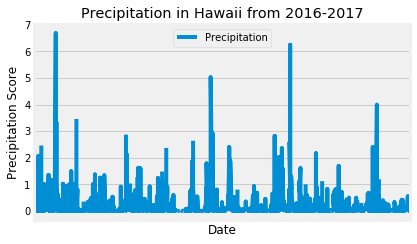

In [78]:
# plotting with pandas is not showing max value when using bar but shows max when using line
sorted_df.plot(title="Precipitation in Hawaii from 2016-2017")
plt.xlabel("Date")
plt.ylabel("Precipitation Score")
plt.xticks([])
plt.legend(loc=9)
plt.savefig("images/prcp-line.png", bbox_inches="tight")

plt.show()

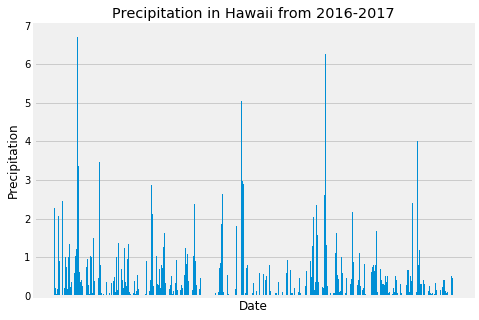

In [79]:
# pyplot shows all values properly
plt.figure(figsize=(7,5))
plt.bar(sorted_df.index,sorted_df["Precipitation"])
plt.title("Precipitation in Hawaii from 2016-2017")
plt.xticks([])
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.savefig("images/prcp-bar.png", bbox_inches="tight")

plt.show()

#### Summary Stats

In [18]:
# show summary stats
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Station Analysis

In [19]:
# inspect station columns
cols = inspector.get_columns('station')
for c in cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
names = session.query(Station.station,Station.name).group_by(Station.station).all()
names

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

In [21]:
# find how many stations
stations = session.query(Station.id)
stations.count()

9

In [22]:
# query count of each station
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# find most active station for next query
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).first()
most_active

('USC00519281', 2772)

In [24]:
# query stats for most active station
most_active_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                                filter(Measurement.station == most_active[0]).all()
most_active_stats

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# station with highest temp observations
highest_temps = session.query(Measurement.station,
                              func.count(Measurement.tobs)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).first()
highest_temps

('USC00519281', 2772)

In [26]:
# get the temp stats for the station with the highest temp observations
temps = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).\
                        filter(Measurement.station == highest_temps[0]).all()
temps_df = pd.DataFrame(temps, columns=["Temperature"])
temps_df.head()

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


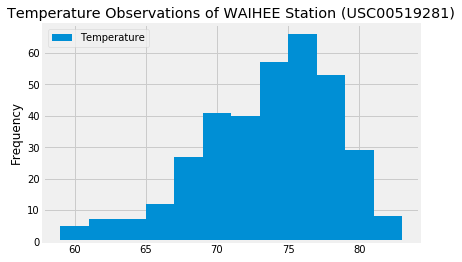

In [27]:
# plot hist
temps_df.plot.hist(bins=12, title="Temperature Observations of WAIHEE Station (USC00519281)")
plt.savefig("images/waihee-temps.png", bbox_inches="tight")

plt.show()

### Part 2: API Routes with FLASK

Reference climate.py for Flask routes using above analyses.

### Part 3: Future Analysis

#### Functions that can be used for future analysis of particular dates for taking a trip

In [57]:
# return the tmin, tmax, and tavg of the last years' data
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

start = str(year_ago)
end = latest_date[0]
print(f"The minimum temperature was {calc_temps(start, end)[0][0]}"
      f", the maximum temperature was {calc_temps(start, end)[0][2]}"
     f", and the average temperature was {calc_temps(start, end)[0][1]}.")

The minimum temperature was 58.0, the maximum temperature was 87.0, and the average temperature was 74.59058295964125.


In [58]:
# calculate the daily normals (averages for tmin, tmax, and tavg for all historic data matching a specific month and day
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
print(f"The minimum temperature was {daily_normals('12-31')[0][0]}"
      f", the maximum temperature was {daily_normals('12-31')[0][2]}"
     f", and the average temperature was {daily_normals('12-31')[0][1]}.")

The minimum temperature was 56.0, the maximum temperature was 77.0, and the average temperature was 68.27906976744185.
